# Bond Options Black Karasinski Model

In [16]:
import sys
sys.path.append("..")
sys.path.append("..\\..")

In [17]:
from importlib import reload

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [19]:
from financepy.finutils.FinDate import FinDate
from financepy.models.FinBlackKarasinskiRateModel import FinBlackKarasinskiRateModel
from financepy.finutils.FinHelperFunctions import printTree
from financepy.market.curves.FinDiscountCurve import FinDiscountCurve
from financepy.products.bonds.FinBond import FinBond
from financepy.finutils.FinFrequency import FinFrequencyTypes
from financepy.finutils.FinDayCount import FinDayCountTypes
from financepy.finutils.FinGlobalVariables import gDaysInYear

# American Bond Option Valuation

We value an American style option on a coupon paying bond.

In [20]:
settlementDate = FinDate(1, 12, 2019)

The bond pays 5% semi-annually for 10 years.

In [21]:
maturityDate = settlementDate.addTenor("10Y")
coupon = 0.05
frequencyType = FinFrequencyTypes.SEMI_ANNUAL
accrualType = FinDayCountTypes.ACT_ACT_ICMA
bond = FinBond(maturityDate, coupon, frequencyType, accrualType)

The option expires in 18 months with a strike of 105

In [22]:
expiryDate = settlementDate.addTenor("18m")
strikePrice = 105.0
face = 100.0

We set the BK model to have 20% of lognormal rate volatility and 0.05 of mean-reversion

In [23]:
sigma = 0.20
a = 0.05

We set up a flat discount curve at 5%

In [24]:
tmat = (maturityDate - settlementDate) / gDaysInYear
times = np.linspace(0, tmat, 20)
dfs = np.exp(-0.05*times)
discountCurve = FinDiscountCurve(settlementDate, times, dfs)

We can price the basic bond without any option

In [25]:
price = bond.fullPriceFromDiscountCurve(settlementDate, discountCurve)

In [26]:
print("Bond Price:", price)

Bond Price: 99.50391846904128


Now we price the option - the tree only needs to go out to the expiry date of the option

In [27]:
numTimeSteps = 100

In [28]:
numStepsList = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000]

50 1.427139397583793 99.50391846907506
100 0.7058192050849276 99.5039184690323
150 1.3199948525356604 99.50391846903759
200 0.7039518611374441 99.50391846904117
250 1.330164327591152 99.50391846904168
300 0.6906233468295798 99.50391846904172
400 0.7007187479359808 99.50391846904154
500 0.6968532975134839 99.50391846904145
600 0.6978872172869206 99.5039184690413
700 0.6994071827820022 99.50391846904125
800 0.6967485658845795 99.50391846904111
900 0.6974054554454544 99.50391846904125
1000 0.6988697865524794 99.50391846904121


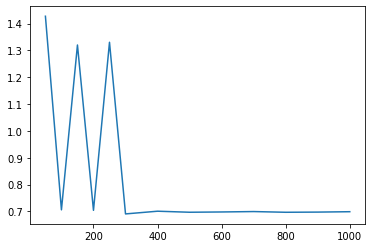

In [29]:
treeVector = []
for numTimeSteps in numStepsList:
    model = FinBlackKarasinskiRateModel(a, sigma)
    model.buildTree(settlementDate, maturityDate, numTimeSteps, discountCurve)
    vOption, vBond = model.bondOption(settlementDate, expiryDate, strikePrice, face, bond, True)
    treeVector.append(vOption)
    print(numTimeSteps, vOption, vBond)

plt.plot(numStepsList, treeVector);    

The option price converges towards something close to the price of 0.699 mentioned in the book by Hull (Fig 28.11). There is a convergence issue at 300 steps with the bond price that needs to be examined. It relates to a numerical issue regarding the coupon payment and expiry date being close together.